## **Importing Libraries** 

In [1]:
import os
import gc
import cv2
import json
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
import pyarrow as pa
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink
import mediapipe as mp
import tensorflow as tf

2024-05-26 20:55:04.883186: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 20:55:04.926212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 20:55:04.926261: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 20:55:04.926323: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 20:55:04.936644: I tensorflow/core/platform/cpu_feature_g

---

## **Data Loading** 

In [2]:
with open('datasets/wlasl_dataset/WLASL_v0.3.json', 'r') as json_file:
    all_data = json.load(json_file)

In [3]:
video_dir = 'datasets/wlasl_dataset/videos'
backup_dir = 'datasets/wlasl2000_resized/videos'
try:
  os.mkdir('working')
except:
  pass

In [4]:
data = []

for i in tqdm(range(len(all_data)), ncols=100):
  gloss = all_data[i]['gloss']
  instances = all_data[i]['instances']
  for instance in instances:
    video_id = instance['video_id']
    if os.path.exists(os.path.join(video_dir, f'{video_id}.mp4')):
      video_path = os.path.join(video_dir, f'{video_id}.mp4')
    elif os.path.exists(os.path.join(backup_dir, f'{video_id}.mp4')):
      video_path = os.path.join(backup_dir, f'{video_id}.mp4')
    else:
      continue
      
    frame_start = instance['frame_start']
    frame_end = instance['frame_end']
    split = instance['split']
    data.append({
      'gloss': gloss,
      'video_path': video_path,
      'frame_start': frame_start,
      'frame_end': frame_end,
      'split': split
    })

# Convert data list to DataFrame
df = pd.DataFrame(data)

100%|████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 30671.89it/s]


In [5]:
df.head()

,gloss,video_path,frame_start,frame_end,split
0,book,datasets/wlasl_dataset/videos/69241.mp4,1,-1,train
1,book,datasets/wlasl2000_resized/videos/65225.mp4,1,-1,train
2,book,datasets/wlasl2000_resized/videos/68011.mp4,1,-1,train
3,book,datasets/wlasl2000_resized/videos/68208.mp4,1,60,train
4,book,datasets/wlasl2000_resized/videos/68012.mp4,1,-1,train


## **Landmark Detection**

In [6]:
# Initialize MediaPipe solutions
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
mp_face = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Initialize MediaPipe Hands, Pose, and Face
hands = mp_hands.Hands(
  static_image_mode=False,
  max_num_hands=2,
  min_detection_confidence=0.5
)
pose = mp_pose.Pose(
  static_image_mode=False,
  model_complexity=1,
  min_detection_confidence=0.5
)
face = mp_face.FaceMesh(
  static_image_mode=False,
  max_num_faces=1,
  min_detection_confidence=0.5
)

# Filter indices for hands, pose, and face
hand_filters = list(range(21))
pose_filters = [11, 12, 13, 14, 15, 16]
face_filters = [
  0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
  61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
  107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
  155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
  234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
  293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
  332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
  381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
  415, 454, 466, 468, 473
]

def extract_landmarks(landmarks, indices):
  return [(lm.x, lm.y, lm.z) for i, lm in enumerate(landmarks.landmark) if i in indices]

def get_hands(rgb_frame):
  hand_results = hands.process(rgb_frame)
  hand_landmarks = []
  if hand_results.multi_hand_landmarks:
    for hand_landmarks_instance in hand_results.multi_hand_landmarks:
      hand_landmarks.append(extract_landmarks(hand_landmarks_instance, hand_filters))
  while len(hand_landmarks) < 2:
    hand_landmarks.append(None)
  return hand_landmarks[:2]

def get_pose(rgb_frame):
  pose_results = pose.process(rgb_frame)
  if pose_results.pose_landmarks:
    return extract_landmarks(pose_results.pose_landmarks, pose_filters)
  return None

def get_face(rgb_frame):
  face_results = face.process(rgb_frame)
  if face_results.multi_face_landmarks:
    return [extract_landmarks(face_landmarks_instance, face_filters) for face_landmarks_instance in face_results.multi_face_landmarks]
  return []

def extract_landmarks_from_image(image):
  rgb_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  with ThreadPoolExecutor(max_workers=3) as executor:
    hands_future = executor.submit(get_hands, rgb_frame)
    pose_future = executor.submit(get_pose, rgb_frame)
    face_future = executor.submit(get_face, rgb_frame)

    hand_landmarks = hands_future.result()
    pose_landmarks = pose_future.result()
    face_landmarks = face_future.result()

  return {
    "hand_landmarks": hand_landmarks,
    "pose_landmarks": pose_landmarks,
    "face_landmarks": face_landmarks
  }

def get_video_landmarks(video_path, start_frame=1, end_frame=-1):
  data = []
  cap = cv2.VideoCapture(video_path)
  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  if end_frame == -1 or end_frame > total_frames:
    end_frame = total_frames

  cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame - 1)

  while cap.isOpened():
    frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    if frame_number > end_frame:
      break

    ret, frame = cap.read()
    if not ret:
      break

    frame_landmarks = extract_landmarks_from_image(frame)
    frame_landmarks["frame"] = frame_number
    data.append(frame_landmarks)

  cap.release()
  df = pd.DataFrame(data)
  return df

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1716731707.237028   39067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [7]:
def draw_landmarks_image(image, landmarks):
  for hand_landmarks in landmarks["hand_landmarks"]:
    if hand_landmarks:
      for landmark in hand_landmarks:
        x, y, _ = landmark
        cv2.circle(image, (int(x * image.shape[1]), int(y * image.shape[0])), 10, (0, 255, 0), -1)

  if landmarks["pose_landmarks"]:
    for landmark in landmarks["pose_landmarks"]:
      x, y, _ = landmark
      cv2.circle(image, (int(x * image.shape[1]), int(y * image.shape[0])), 10, (0, 0, 255), -1)

  for face_landmarks_instance in landmarks["face_landmarks"]:
    for landmark in face_landmarks_instance:
      x, y, _ = landmark
      cv2.circle(image, (int(x * image.shape[1]), int(y * image.shape[0])), 10, (255, 0, 0), -1)

  return image

def draw_landmarks_video(input_path, output_path, video_landmarks, start_frame=1, end_frame=-1):
  cap = cv2.VideoCapture(input_path)
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  
  out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (frame_width, frame_height))

  if end_frame == -1 or end_frame > total_frames:
    end_frame = total_frames

  cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame - 1)

  while cap.isOpened():
    frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    if frame_number > end_frame:
      break

    ret, frame = cap.read()
    if not ret:
      break

    frame_landmarks = video_landmarks.iloc[frame_number - 1]
    annotated_frame = draw_landmarks_image(frame, frame_landmarks)

    out.write(annotated_frame)

  cap.release()
  out.release()


W0000 00:00:1716731707.245233   39117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1716731707.250403   39134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1716731707.254994   39067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1716731707.280064   39090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1716731707.291455   39090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


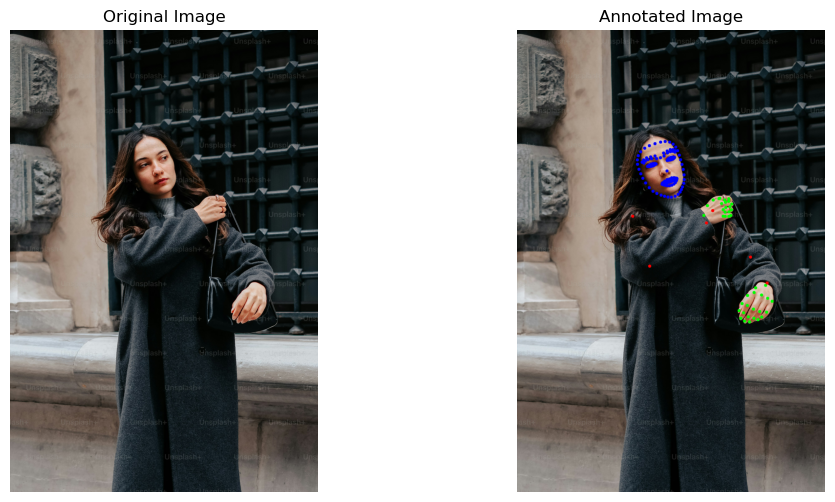

In [8]:
import requests
from PIL import Image
from io import BytesIO

# Fetch and process the image
image_url = 'https://plus.unsplash.com/premium_photo-1673287635678-8d812deb4fc2?q=80&w=1974&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Annotate the image
test_image_landmarks = extract_landmarks_from_image(img)
annotated_img = draw_landmarks_image(img.copy(), test_image_landmarks)

# Display images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img[:,:,::-1])
axes[0].axis('off')
axes[0].set_title('Original Image')

# Annotated image
axes[1].imshow(annotated_img[:,:,::-1])
axes[1].axis('off')
axes[1].set_title('Annotated Image')

plt.show()

# Save the annotated image
Image.fromarray(annotated_img).save("working/test_output_image.png")

In [9]:
video_path = df['video_path'][0]
output_path = 'working/test_output_video.mp4'
test_video_landmarks = get_video_landmarks(video_path, 1, -1)
draw_landmarks_video(video_path, output_path, test_video_landmarks)


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


## **Landmark Encoding**

In [ ]:
dfs = []
for i in tqdm(range(len(df)), ncols=100):
  video_path = df['video_path'][i]
  video_landmarks = get_video_landmarks(video_path, df['frame_start'][i], df['frame_end'][i])
  dfs.append(video_landmarks)

landmark_df = pd.concat(dfs, ignore_index=True)
table = pa.Table.from_pandas(landmark_df)
parquet_path = 'working/landmarks.parquet'
pa.parquet.write_table(table, parquet_path)